In [1]:
# Preprocessing images and labels for training
# Author: Chengchao Xu
# Date: 2025-03-11

# virtual environment: mini-proj
# "conda activate mini-proj"

# libraries
import os
import numpy as np
from skimage import feature, io, color, exposure, filters
import matplotlib.pyplot as plt


Original image shape: (996, 1500)


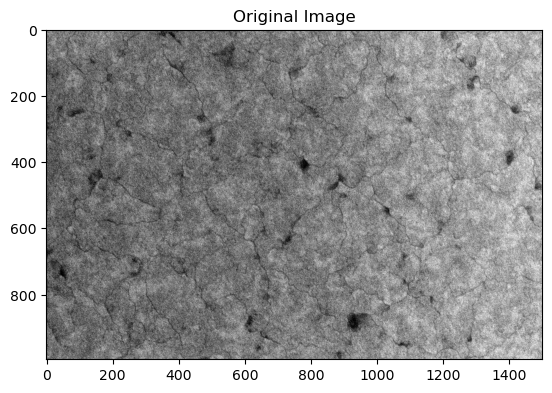

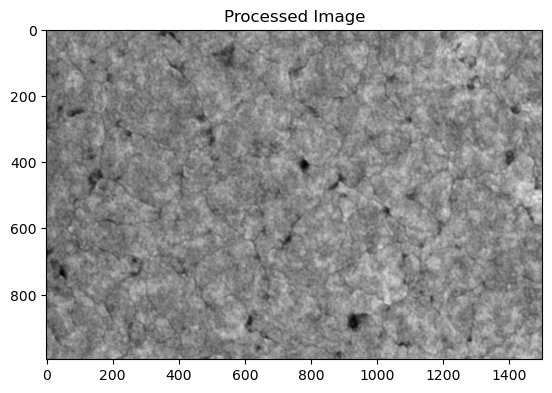

In [2]:
# Load and preprocess image
image = io.imread('train_image.tif')
# Convert to grayscale if necessary
if len(image.shape) > 2:
    image = color.rgb2gray(image)
print(f"Original image shape: {image.shape}")

# display the image
plt.imshow(image, cmap='gray')
plt.title('Original Image')

# Optional
from skimage.morphology import disk, white_tophat
selem = disk(50)  # Size controls how large of background variations to remove
image = white_tophat(image, selem)
# Alternative: background subtraction using gaussian blur
# background = filters.gaussian(image, sigma=50)
# image_no_bg = image - background

# Step 2: Enhance contrast
# Using Contrast Limited Adaptive Histogram Equalization (CLAHE)
# image_enhanced = exposure.equalize_adapthist(image)
# Alternative: Simple contrast stretching
image_enhanced = exposure.rescale_intensity(image)

# Step 3: Gaussian blur to denoise
image_denoised = filters.gaussian(image_enhanced, sigma=2)

# Display the processed image
image_processed = image_denoised
plt.figure()
plt.imshow(image_processed, cmap='gray')
plt.title('Processed Image')

# Set scale factor, measured using imageJ
SCALE_FACTOR = 0.603 # pixel/nm

Feature shape: (996, 1500, 16)


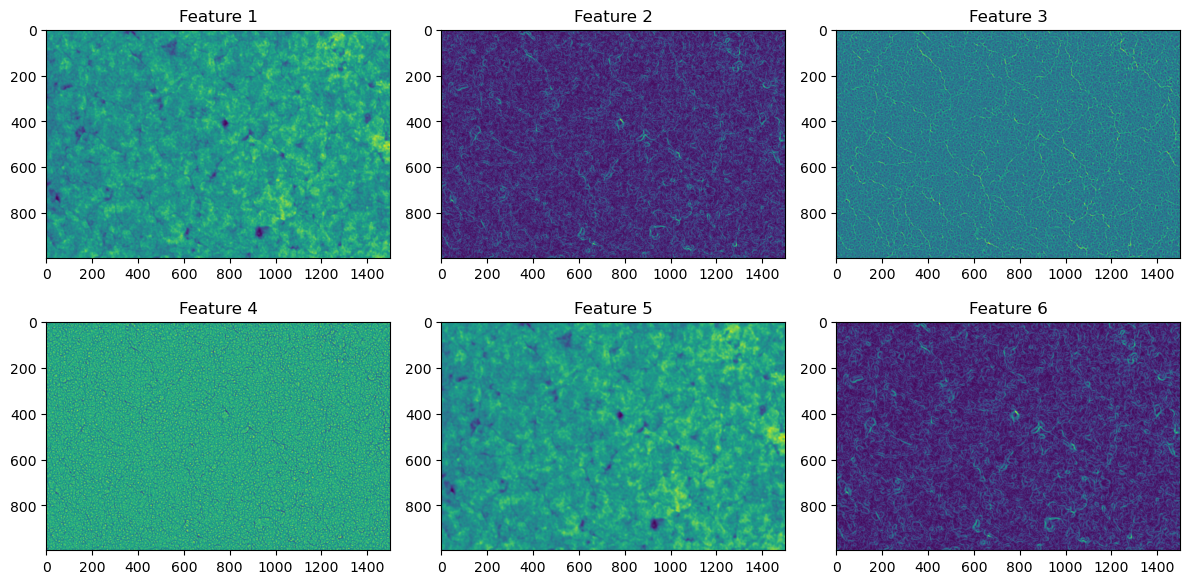

In [3]:
# skimage feature extraction
features = feature.multiscale_basic_features(
    image=image_processed,
    intensity=True,
    texture=True,
    edges=True,
    sigma_min=1,
    sigma_max=10,
    channel_axis=None # no color channel
)
print(f"Feature shape: {features.shape}")

# visualize six features
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(features[:, :, i], cmap='viridis') # false color
    ax.set_title(f"Feature {i+1}")
plt.tight_layout()
plt.show()

Label shape: (996, 1500)


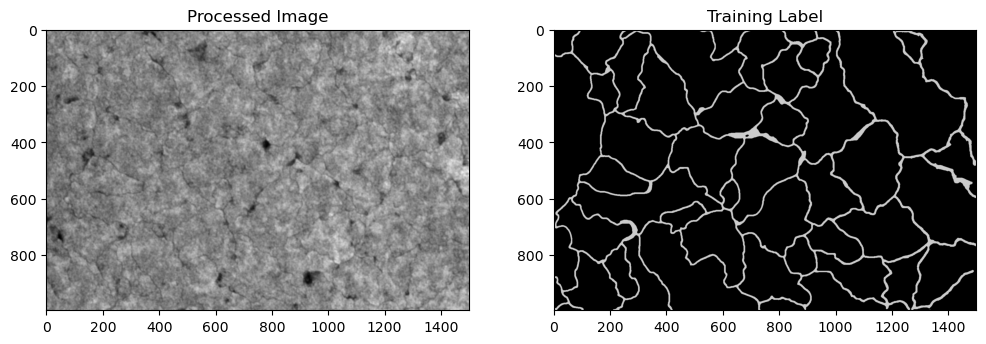

In [4]:
binary_label = io.imread('train_labels.tif')
print(f"Label shape: {binary_label.shape}")

# convert to training label
train_label = np.zeros_like(binary_label, dtype=np.uint8)
train_label[binary_label == 0] = 0 # Black background = grains
train_label[binary_label == 255] = 1 # White = grain boundaries

# display the label and original image
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_processed, cmap='gray')
plt.title('Processed Image')

plt.subplot(122)
plt.imshow(train_label, cmap='nipy_spectral')
plt.title('Training Label')
plt.show()

In [5]:
# Add this to your notebook after you've prepared your features and labels

import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import time
from sklearn.utils import class_weight

# Calculate class weights to handle imbalance
uniqe, counts = np.unique(train_label, return_counts=True)
print(f"Unique labels percentage:")
for i, c in zip(uniqe, counts):
    print(f"Label {i}: {c/np.sum(counts)*100:.2f}%")

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_label),
    y=train_label.flatten()
)
class_weight_dict = {i: w for i, w in zip(uniqe, class_weights)}
print(f"Class weights:", class_weight_dict)


Unique labels percentage:
Label 0: 91.63%
Label 1: 8.37%
Class weights: {0: 0.545668908267724, 1: 5.974183848110174}


In [6]:
# Prepare data for training
X = features.reshape(-1, features.shape[2])
y = train_label.flatten()

# Define the parameter grid
param_grid = {
    'n_estimators': [30, 40, 50],  # Number of trees
    'max_depth': [5, 10, 15],      # Maximum depth of trees
    'min_samples_split': [2, 3]    # Minimum samples required to split a node
}

# Setup stratified k-fold cross validation
# Using 3 folds for faster execution as requested
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialize the classifier with class weights
rf = RandomForestClassifier(
    class_weight=class_weight_dict,
    n_jobs=-1  # Use all available cores
)


Starting grid search with cross-validation...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=30; total time= 5.4min
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=30; total time= 5.4min
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=30; total time= 5.4min
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=40; total time= 6.6min
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=40; total time= 6.7min
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=40; total time= 6.7min
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=50; total time= 8.8min
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=50; total time= 9.2min
[CV] END ..max_depth=5, min_samples_split=3, n_estimators=30; total time= 5.1min
[CV] END ..max_depth=5, min_samples_split=3, n_estimators=30; total time= 5.1min
[CV] END ..max_depth=5, min_samples_split=3, n_estimators=30; total time= 5.2min
[C

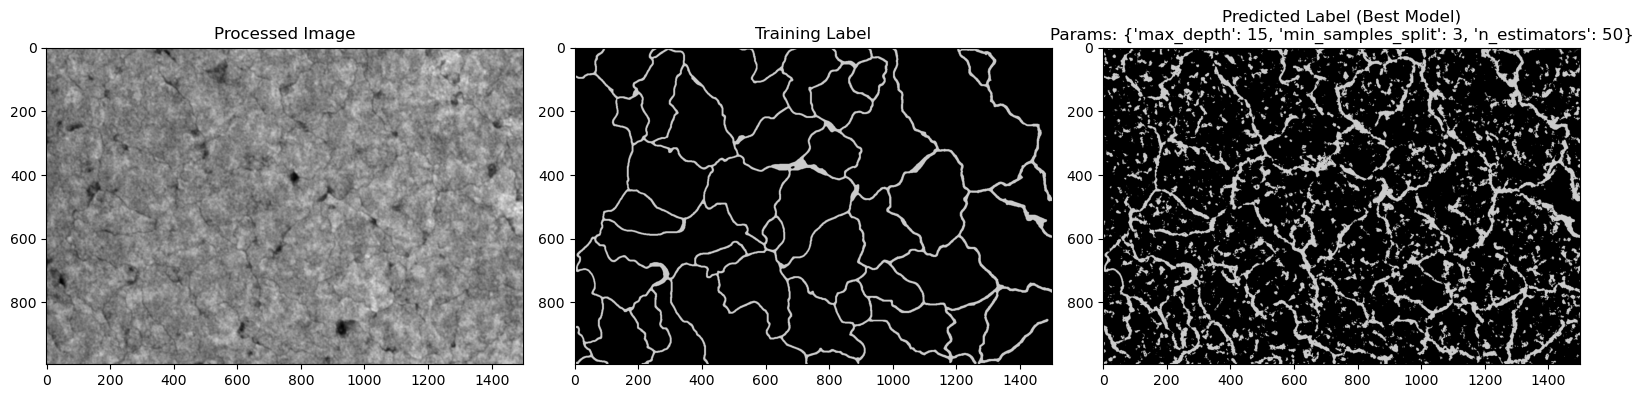

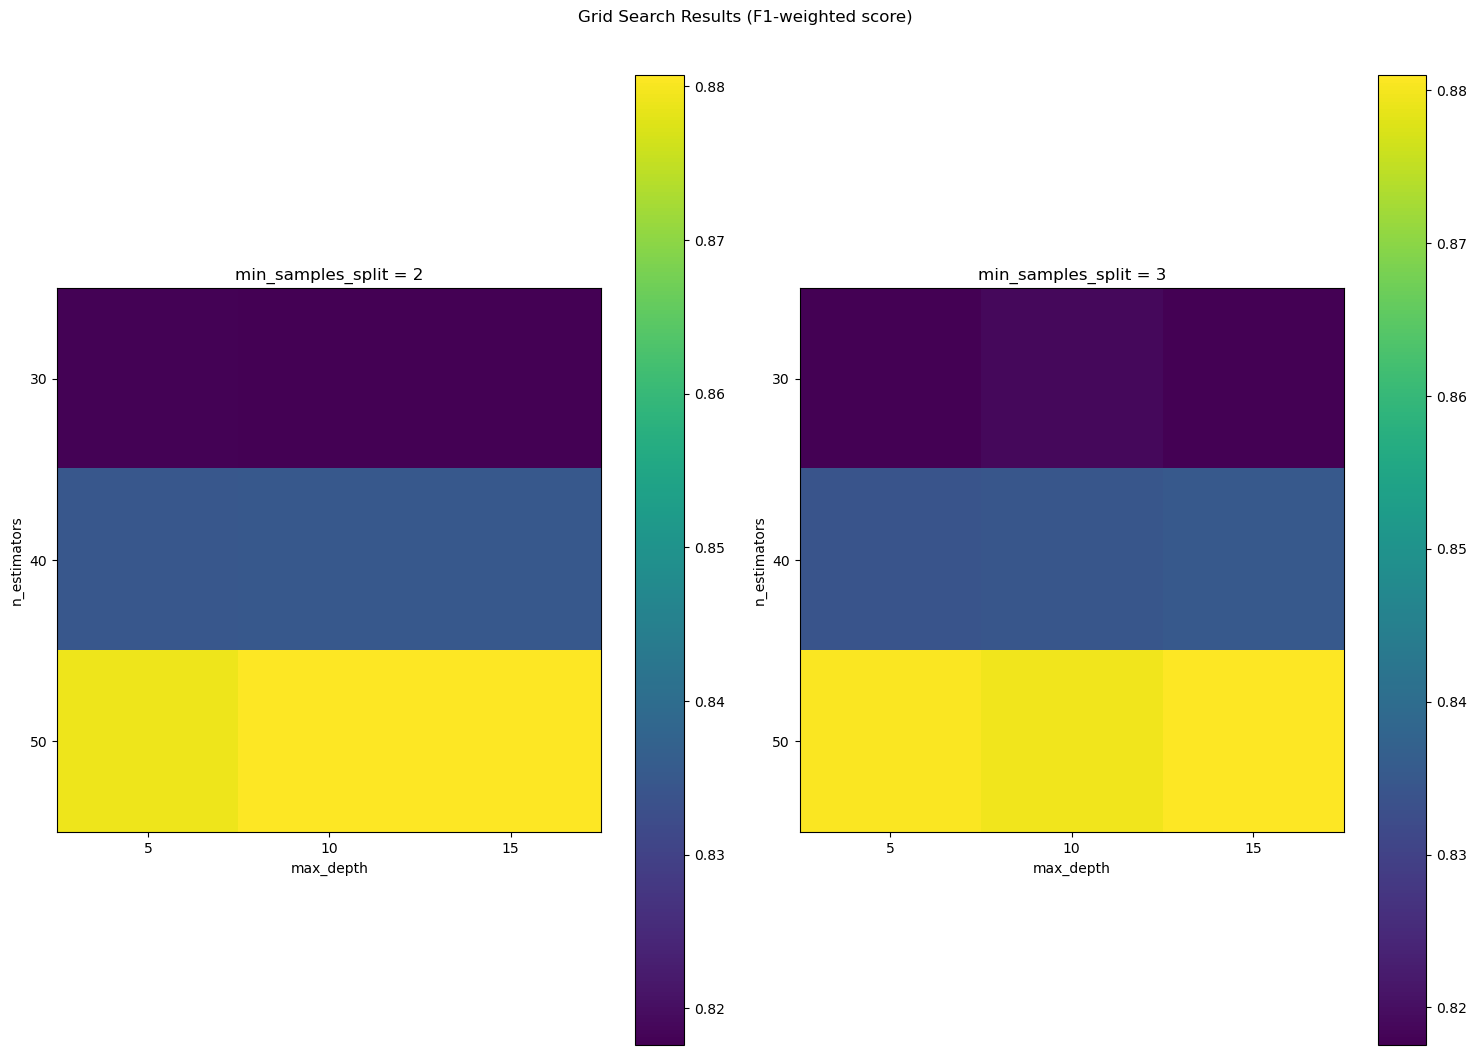

In [7]:

# Setup GridSearchCV with stratified CV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring='f1_weighted',  # Good for imbalanced datasets
    verbose=2,
    n_jobs=-1  # Use all cores for parallel execution
)

# Measure execution time
start_time = time.time()

# Fit the grid search model
print("Starting grid search with cross-validation...")
grid_search.fit(X, y)
print(f"Grid search completed in {time.time() - start_time:.2f} seconds")

# Print the best parameters
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Extract the best model
best_rf_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_rf_model.predict(X)
y_pred_image = y_pred.reshape(train_label.shape)

# Display the results
print("\nClassification Report:")
print(classification_report(y, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y, y_pred)
print(cm)

# Display the prediction results
plt.figure(figsize=(16, 4))

plt.subplot(131)
plt.imshow(image_processed, cmap='gray')
plt.title('Processed Image')

plt.subplot(132)
plt.imshow(train_label, cmap='nipy_spectral')
plt.title('Training Label')

plt.subplot(133)
plt.imshow(y_pred_image, cmap='nipy_spectral')
plt.title(f'Predicted Label (Best Model)\nParams: {grid_search.best_params_}')

plt.tight_layout()
plt.show()

# Create a visual comparison of all models in the grid
plt.figure(figsize=(15, 10))
results = grid_search.cv_results_

# Sort the results by mean test score (descending)
indices = np.argsort(results['mean_test_score'])[::-1]

# Plot grid scores as a heatmap
scores = np.array(results['mean_test_score']).reshape(
    len(param_grid['n_estimators']),
    len(param_grid['max_depth']),
    len(param_grid['min_samples_split'])
)

# Plot for each min_samples_split value
for i, min_samples in enumerate(param_grid['min_samples_split']):
    plt.subplot(1, len(param_grid['min_samples_split']), i+1)
    
    plt.imshow(scores[:, :, i], interpolation='nearest', cmap='viridis')
    plt.title(f'min_samples_split = {min_samples}')
    plt.colorbar()
    
    plt.yticks(np.arange(len(param_grid['n_estimators'])), param_grid['n_estimators'])
    plt.xticks(np.arange(len(param_grid['max_depth'])), param_grid['max_depth'])
    plt.xlabel('max_depth')
    plt.ylabel('n_estimators')
    
plt.tight_layout()
plt.suptitle('Grid Search Results (F1-weighted score)', y=1.05)
plt.show()


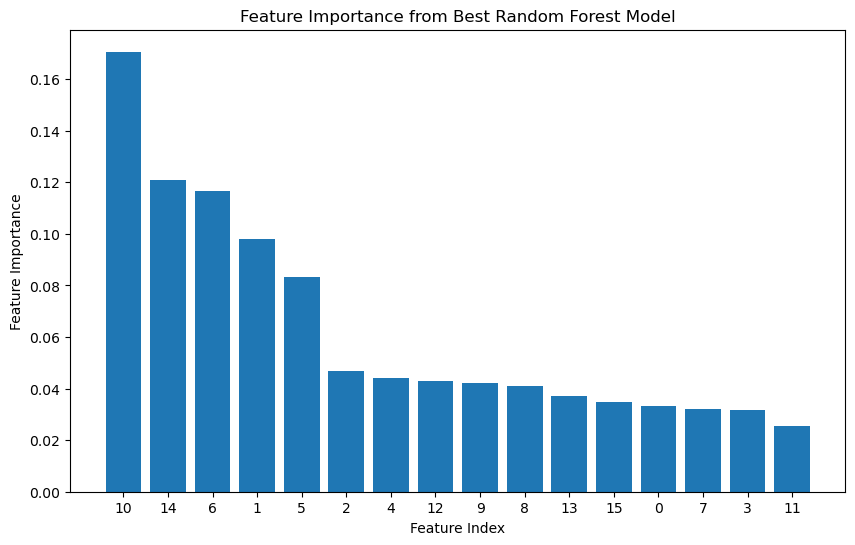

In [8]:

# Save the best model
import joblib
joblib.dump(best_rf_model, 'best_pixel_classifier.joblib')

# Feature Importance
# Display the feature importance from the best model
feature_importance = best_rf_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(features.shape[2]), feature_importance[sorted_idx])
plt.xticks(range(features.shape[2]), sorted_idx)
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Feature Importance from Best Random Forest Model')
plt.show()

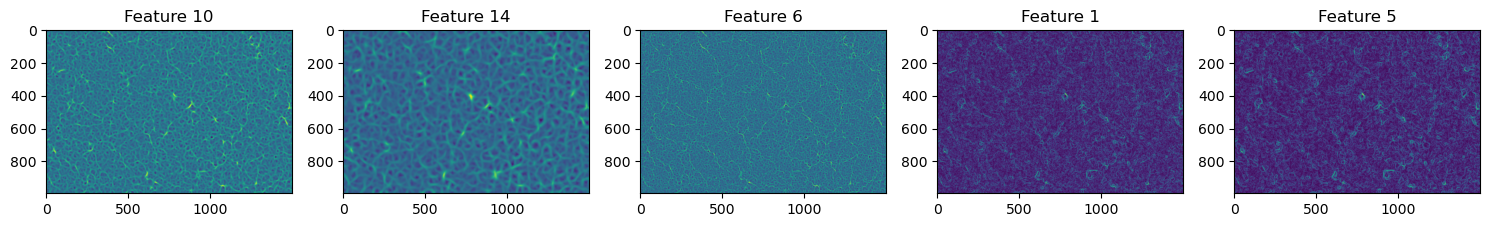

In [ ]:
# visualize the top 5 features
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(features[:, :, sorted_idx[i]], cmap='viridis') # false color
    ax.set_title(f"Feature {sorted_idx[i]}")
plt.tight_layout()
plt.show()
